# <center> <font color='blue'> **Advancing Passive Microwave Retrievals of Precipitation using CloudSat and GPM Coincidences: Integration of Machine Learning with a Bayesian Algorithm** <center>

#### <center> <font color='balck'> Reyhaneh Rahimi and Ardeshir Ebtehaj <center>
#### <center> Saint Anthony Falls Laboratory, Department of Civil Environmental and Geo- Engineering,
#### <center> University of Minnesota <center>
#### <center> Date: August, 2024

---
<p align="justify"> This notebook presents the results of an algorithm known as ShARP_ML, designed for passive microwave retrieval of precipitation using data from the Global Precipitation Measurement (GPM) satellite. The algorithm leverages a dense and deep neural network architecture that utilizes coincidences of brightness temperatures (TBs) from the GPM Microwave Imager (GMI) along with active precipitation retrievals from the Dual-frequency Precipitation Radar (DPR) onboard GPM, and from the CloudSat Cloud Profiling Radar (CPR).

Initially, the ShARP_ML algorithm employs the XGBoost algorithm to detect precipitation occurrence and phase. Subsequent estimation of precipitation rates is achieved through a combination of a Multi-Layer Perceptron (MLP) trained with a focal loss function—aimed at handling the imbalanced distribution of precipitation data—and a Bayesian approach. The results demonstrate the algorithm's ability to accurately reconstruct DPR-derived rainfall and CPR-derived snowfall. Notably, the detection probability exceeds 0.95, while the probability of false alarms remains below 0.01. When precipitation is confirmed, the unbiased root mean squared errors in the estimation of rainfall and snowfall rates using DPR and CPR data, respectively, are less than 2.6 mm/hr and 0.20 mm/hr over both oceans and land.

Additionally, this notebook provides a small test set to evaluate the trained model's performance over oceans and to assess the algorithm's capability to retrieve precipitation over one GMI orbit which passes over the complex terrain of Greenland. Please note that discrepancies between the scores reported here and those in the manuscript can be attributed to the smaller dataset used in this notebook.




   


In [1]:
# # downloading the files from Google drive
!gdown 1qunQjmuwGQusR6JcUKx64tjP08pbOrdm




Downloading...
From (original): https://drive.google.com/uc?id=1qunQjmuwGQusR6JcUKx64tjP08pbOrdm
From (redirected): https://drive.google.com/uc?id=1qunQjmuwGQusR6JcUKx64tjP08pbOrdm&confirm=t&uuid=9ac8c953-c60c-474a-964b-e8e146fd376d
To: /content/github_rev2.zip
100% 427M/427M [00:04<00:00, 90.7MB/s]


In [2]:
!unzip "github_rev2.zip"


Archive:  github_rev2.zip
   creating: github_rev2/
   creating: github_rev2/models/
  inflating: github_rev2/models/snowcover_det_xgb_no_dup.pickle.dat  
  inflating: github_rev2/models/snowcover_det_dnn_2_no_dup.keras  
  inflating: github_rev2/models/snowcover_est_FL_rain_10class_no_dup.keras  
  inflating: github_rev2/models/snowcover_est_FL_snow_10class_no_dup.keras  
  inflating: github_rev2/models/snowcover_reg.keras  
  inflating: github_rev2/models/snowcover_det_dnn_2_no_dup_v2.keras  
  inflating: github_rev2/models/ocean_det_xgb_rev2.pickle.dat  
  inflating: github_rev2/models/ocean_det_xgb_np_dup_rev2.pickle.dat  
  inflating: github_rev2/models/ocean_det_dnn_2_rev2.keras  
  inflating: github_rev2/models/ocean_rain_reg_dnn.keras  
  inflating: github_rev2/models/ocean_est_FL_rain_10class_rev2.keras  
  inflating: github_rev2/models/ocean_est_FL_snow_10class_rev2.keras  
   creating: github_rev2/models/.ipynb_checkpoints/
  inflating: github_rev2/models/land_det_xgb_np_dup

In [ ]:
# To run this code tensorflow 2.12.0 is required
!pip install tensorflow==2.12.0 > /dev/null 2>&1


In [1]:
import os
os.chdir('/content/github_rev2')
import utils as utils
import pickle
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.io import loadmat
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, linear_model, datasets
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    make_scorer,
    f1_score,
)
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import Ridge
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Dense,
    Activation,
    Dropout,
    Input,
    BatchNormalization,
)
from tensorflow.keras import layers, Sequential
from tensorflow.keras import Model
from tabulate import tabulate
import tensorflow as tf
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Defining the class for focal loss function.
# This is necessary for loading the estimation models
class CategoricalFocalLoss(tf.keras.losses.Loss):

        def __init__(self, alpha, gamma):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma

        def call(self, y_true, y_pred):

            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
            cross_entropy = -y_true * K.log(y_pred)
            loss = self.alpha * K.pow(1 - y_pred, self.gamma) * cross_entropy
            return K.mean(K.sum(loss, axis=-1))

### Loading the data


In [3]:
# Below is the subset of ocean dataframe to test the trained models
# This is 20% of the originl testset
path = '/content/github_rev2/'
surf_type = 'ocean'
data = pd.read_csv(os.path.join(path, f'data/{surf_type}_subset_rev2.csv'))
data.head(10)
X_tst, y_tst = utils.process_and_normalize(data, surf_type)


### Loading the models

In [4]:
# The models are loaded here

path_models   = os.path.join(path, 'models/')
path_features = os.path.join(path, 'features/')

model_dtc_xgb = pickle.load(open((path_models+f'{surf_type}_det_xgb_rev2.pickle.dat'), "rb"))

# model_dtc_dnn = keras.models.load_model(path_models + f"{surf_type}_det_dnn_2.h5")

model_rtv_rain = keras.models.load_model(path_models + f'{surf_type}_est_FL_rain_10class_rev2.keras',\
                                                   custom_objects={'CategoricalFocalLoss': utils.CategoricalFocalLoss(alpha=0.25, gamma=2)}, compile=False)

model_rtv_snow = keras.models.load_model(path_models + f'{surf_type}_est_FL_snow_10class_rev2.keras',\
                                                  custom_objects={'CategoricalFocalLoss': utils.CategoricalFocalLoss(alpha=0.25, gamma=2)}, compile=False)

features_data = sio.loadmat(path_features + f'feature_dic_{surf_type}_rev2.mat')
X_trn_rain_features = features_data[f'X_trn_rain_features_{surf_type}']
y_trn_rain = features_data[f'y_train_rain_{surf_type}'][:,1]

X_trn_snow_features = features_data[f'X_trn_snow_features_{surf_type}']
y_trn_snow = features_data[f'y_train_snow_{surf_type}'][:,1]
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost.core')

In [8]:
features_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X_trn_rain_features_ocean', 'X_tst_rain_features_ocean', 'y_train_rain_ocean', 'y_test_rain_ocean', 'X_trn_snow_features_ocean', 'X_tst_snow_features_ocean', 'y_train_snow_ocean', 'y_test_snow_ocean'])

In [5]:
# print more scores
prd_xgb = model_dtc_xgb.predict(X_tst)

utils.classification_score(y_tst[:,0], prd_xgb)

+----------+--------+--------+
| Metric   |   Rain |   Snow |
+==========+========+========+
| TPR      |  0.988 |  0.992 |
+----------+--------+--------+
| FPR      |  0.004 |  0.003 |
+----------+--------+--------+
| AUC      |  0.992 |  0.995 |
+----------+--------+--------+
| F1 Score |  0.987 |  0.977 |
+----------+--------+--------+


(0.0, 1.0, 0.0, 1.0)

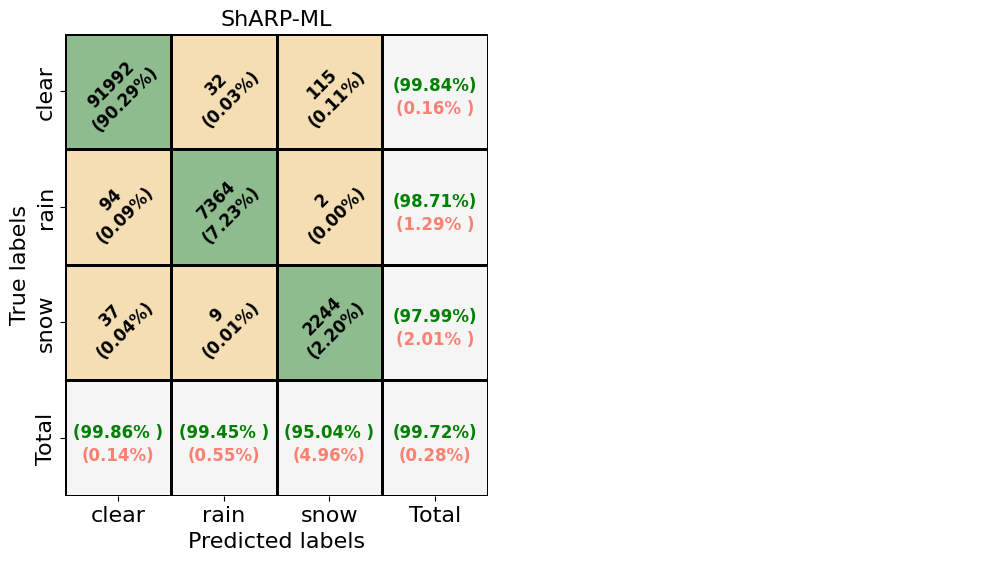

In [ ]:
# plot the confusion matrix
fig, axes = plt.subplots(1,2,figsize=(12, 6))
axes = axes.ravel()
utils.plot_detailed_confusion_matrix(y_tst[:,0], prd_xgb, axes[0], 'ShARP-ML', True, True)
axes[1].axis('off')


(0.0, 1.0, 0.0, 1.0)

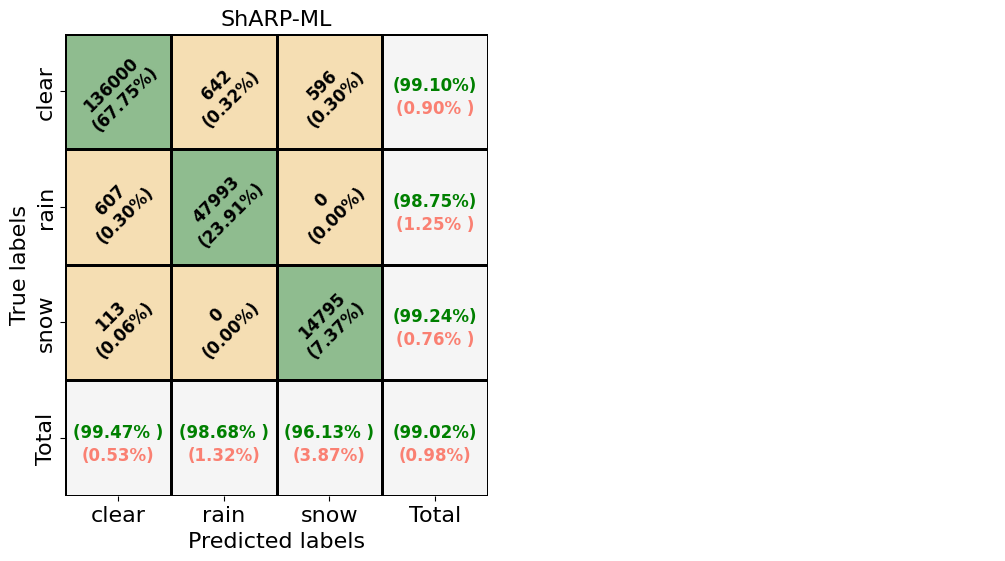

In [6]:
# plot the confusion matrix
fig, axes = plt.subplots(1,2,figsize=(12, 6))
axes = axes.ravel()
utils.plot_detailed_confusion_matrix(y_tst[:,0], prd_xgb, axes[0], 'ShARP-ML', True, True)
axes[1].axis('off')


### Estimation using ShARP_ML

In [8]:
# # Getting the features on the one to last layer


new_input_rain   = model_rtv_rain.layers[0].input
new_output_rain  = model_rtv_rain.get_layer('fc_3').output
model_rtv_rain_ = tf.keras.Model(new_input_rain, new_output_rain)

new_input_snow   = model_rtv_snow.layers[0].input
new_output_snow  = model_rtv_snow.get_layer('fc_3').output
model_rtv_snow_ = tf.keras.Model(new_input_snow, new_output_snow)


In [9]:
feature_prd_snow = model_rtv_snow_.predict(X_tst)
feature_prd_rain = model_rtv_rain_.predict(X_tst)

6274/6274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
6274/6274 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [10]:
k_nn_rain, k_nn_snow = 20, 20
rate_rain_pred_knn, indices_rain = utils.rate_knn(X_trn_rain_features, feature_prd_rain, y_trn_rain, k_nn_rain)
rate_snow_pred_knn, indices_snow = utils.rate_knn(X_trn_snow_features, feature_prd_snow, y_trn_snow, k_nn_snow)

rate_rain_pred_ridge = utils.ridge_estimation(
    X_trn_rain_features, feature_prd_rain, indices_rain, y_trn_rain, rate_rain_pred_knn
    )

rate_snow_pred_ridge = utils.ridge_estimation(
    X_trn_snow_features, feature_prd_snow, indices_snow, y_trn_snow, rate_snow_pred_knn
    )


bias is 0.274
mae is 0.894
rmse is 2.472
bias is 0.000
mae is 0.124
rmse is 0.203


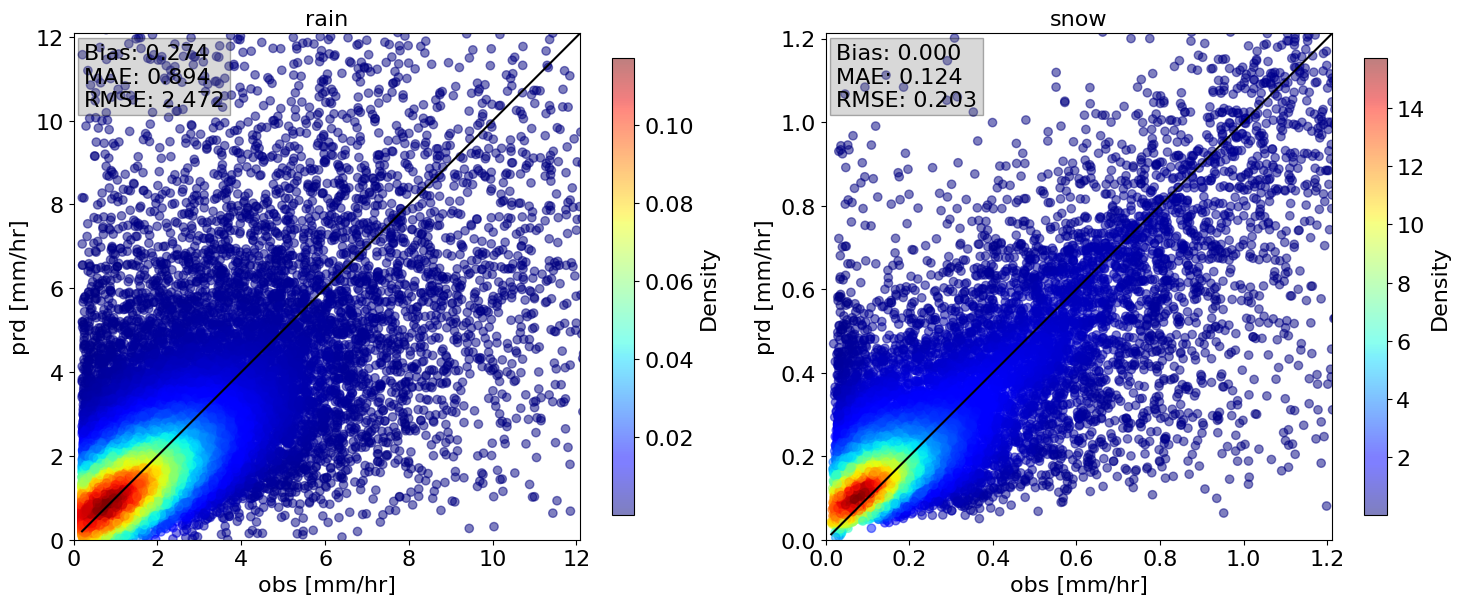

In [11]:
# The result are different from the paper since testset is 20% of the original testset
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
plt.rcParams.update({'font.size': 16})
# Call the plot function for each subplot
utils.plot_density_scatter(axes[0], y_tst, rate_rain_pred_ridge, prd_xgb, 1, 0)
utils.plot_density_scatter(axes[1], y_tst, rate_snow_pred_ridge, prd_xgb, 2, 0)
axes[0].set_title('rain')
axes[1].set_title('snow')

plt.tight_layout()
plt.show()

bias is 0.351
mae is 0.684
rmse is 1.669
bias is -0.002
mae is 0.129
rmse is 0.207


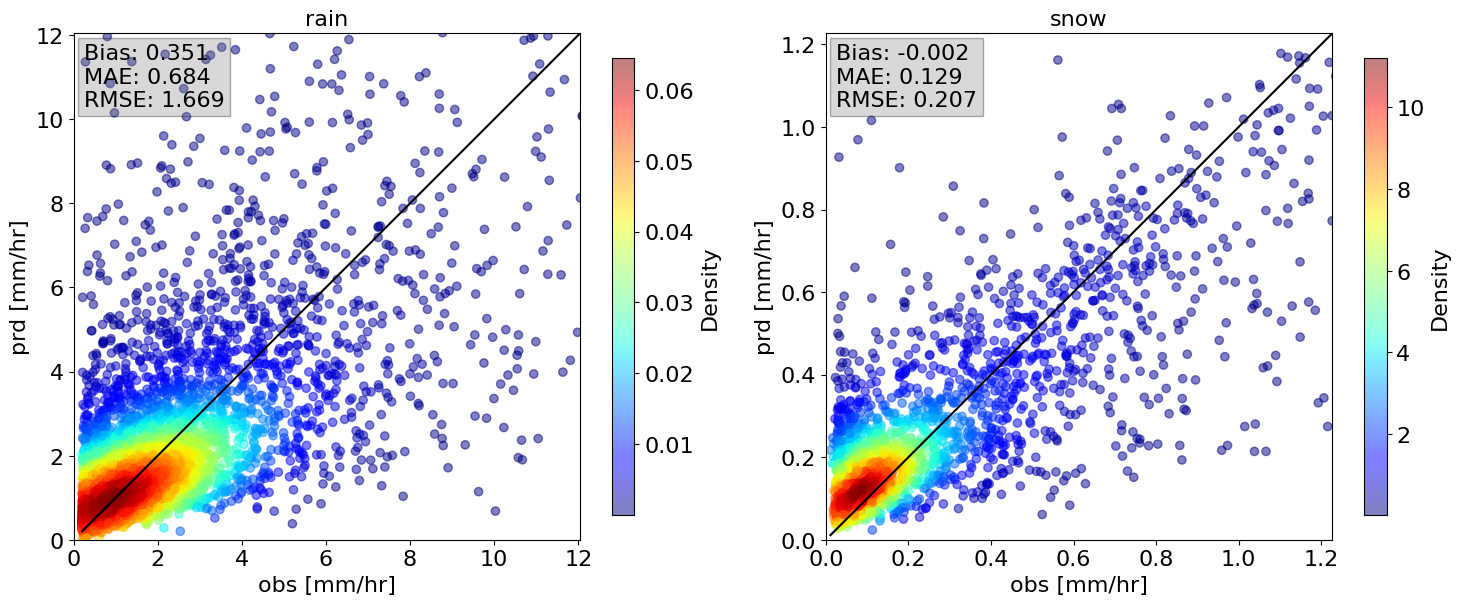

In [ ]:
# The result are different from the paper since testset is 20% of the original testset
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
plt.rcParams.update({'font.size': 16})
# Call the plot function for each subplot
utils.plot_density_scatter(axes[0], y_tst, rate_rain_pred_ridge, prd_xgb, 1, 0)
utils.plot_density_scatter(axes[1], y_tst, rate_snow_pred_ridge, prd_xgb, 2, 0)
axes[0].set_title('rain')
axes[1].set_title('snow')

plt.tight_layout()
plt.show()

## Orbital retrieval

In [ ]:
# installing the cartopy
!apt-get install -y python3-cartopy > /dev/null 2>&1
!pip install cartopy > /dev/null 2>&1


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
from scipy import io
import glob


In [ ]:
def orbit_retreival(orbit_number):
    models = utils.load_models()
    features_data = utils.load_feature_data()
    stats = utils.load_stats()

    my_files = glob.glob(path + f'/orbital/*{orbit_number}_dics.mat')
    orbit_num = my_files[0][-14:-9]
    X_normalized = utils.preprocess_input_data(my_files[0], stats)
    predictions = utils.predict_features(models, X_normalized)
    localized_rates = utils.localize_retrievals(predictions, features_data, k_nn_rain=20, k_nn_snow=20)
    X_rain, X_snow, X_precip_label, Lat, Lon = utils.reconstruct_orbit(localized_rates, orbit_num)

    print(f"Orbit Number: {orbit_num}")

    return X_rain, X_snow, X_precip_label, Lat, Lon


In [ ]:
X_rain, X_snow, X_precip_label, Lat, Lon = orbit_retreival('03080')
idx_rain = X_precip_label == 1
idx_snow = X_precip_label == 2
X_rain[~idx_rain] = 0
X_snow[~idx_snow] = 0


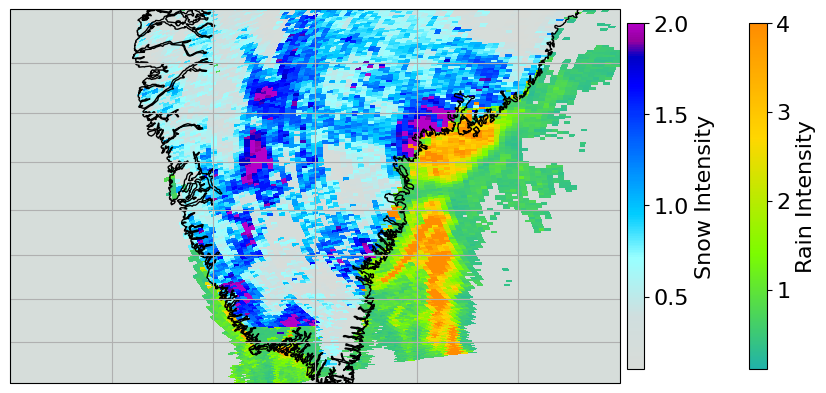

In [ ]:
# Define zones and calculate the image ratio
zones = [-60, -30, 60, 68]
level = 10
im_ratio = X_rain.shape[0] / X_rain.shape[1]
X_rain_masked = np.ma.masked_where(X_rain == 0, X_rain)
X_snow_masked = np.ma.masked_where(X_snow == 0, X_snow)
cmap_rain, cmap_snow = utils.load_colormaps(path + f'/orbital/colormap.mat')

# Create a figure with one subplot using the Mercator projection
fig, ax3 = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.Mercator()})

# Plot rain data
rain_plot = ax3.pcolormesh(
    Lon,
    Lat,
    X_rain_masked,
    cmap=cmap_rain,
    transform=ccrs.PlateCarree(),
    vmin=0.1,
    vmax=4,
)

# Plot snow data
snow_plot = ax3.pcolormesh(
    Lon,
    Lat,
    X_snow_masked,
    cmap=cmap_snow,
    transform=ccrs.PlateCarree(),
    vmin=0.1,
    vmax=2,
)

# Add coastlines and gridlines
ax3.coastlines()
ax3.gridlines(draw_labels=False)

# Set the extent of the plot
ax3.set_extent(zones, ccrs.PlateCarree())

# Add colorbars for rain and snow
cbar_rain = fig.colorbar(rain_plot, ax=ax3, orientation='vertical', fraction=0.046, pad=0.12, shrink = 0.45)
cbar_rain.set_label('Rain Intensity')

cbar_snow = fig.colorbar(snow_plot, ax=ax3, orientation='vertical', fraction=0.046, pad=0.01, shrink = 0.45)
cbar_snow.set_label('Snow Intensity')

plt.show()


## Appendix

### Parameter tuning of XGBDT

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE

def tune_xgb_hyperparameters(X_trn, y_trn):
    """
    Perform hyperparameter tuning for an XGBoost classifier using SMOTE for oversampling the minority class.

    Parameters:
    X_trn (pd.DataFrame or np.ndarray): Training features.
    y_trn (pd.Series or np.ndarray): Training labels.

    Returns:
    dict: Best hyperparameters found by the RandomizedSearchCV.
    """

    # Define the XGBoost model
    model_xgb = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)

    # Define the hyperparameters grid
    param_grid = {
        'max_depth': [15, 20, 25],
        'learning_rate': [0.01, 0.3],
        'n_estimators': [100, 200, 300],
        'min_child_weight': [1, 5, 10],
    }

    # Define a scoring function (F1-score with macro averaging)
    scorer = make_scorer(f1_score, average='macro')

    # Set up Randomized Search
    grid_search = RandomizedSearchCV(estimator=model_xgb, param_distributions=param_grid, cv=5, scoring=scorer, verbose=2, n_jobs=-1, n_iter=10)

    # Fit the grid search
    grid_search.fit(X_trn,  y_trn[:, 0])

    # Print the best parameters
    print("Best parameters found: ", grid_search.best_params_)

    return grid_search.best_params_

In [ ]:
def create_model_reg(n_layers, hidden_units,hidden_units_f, output_unit, dropout):
    inputs = Input(shape=(18,))

    model = Sequential()

    # add first hidden layer
    model.add(Dense(hidden_units, activation='relu', input_shape=(18,), name = "layer_1"))
    model.add(Dropout(dropout))
    #model.add(BatchNormalization())

    # add remaining hidden layers
    for i in range(n_layers-1):
        model.add(Dense(hidden_units, activation='relu', name = f"fc_{i+1}"))
        model.add(Dropout(dropout))

    model.add(Dense(hidden_units_f, activation='relu', name = f"fc_{i+2}"))
    model.add(Dropout(dropout))

    model.add(Dense(output_unit, activation='relu'))


    return model

def est_dataset(X, y, label):
    idx = (y[:,0]==label) #| (y[:,0]==0)
    X = X[idx,:]
    y = y[idx,:]
    return X, y


In [ ]:
# For the detection step use MLP
prd_dnn = model_dtc_dnn.predict(X_tst)
prd_dnn = np.argmax(prd_dnn, axis = 1)

# For the estimation step use MLP- The detailed archicture is below
estimation_model_rain = keras.models.load_model(path_models + 'ocean_rain_reg_dnn_test.h5', compile=False)
estimation_model_snow = keras.models.load_model(path_models + 'ocean_snow_reg_dnn.h5', compile=False)

rate_rain_prd_mlp = estimation_model_rain.predict(X_tst)
rate_snow_prd_mlp = estimation_model_snow.predict(X_tst)




3185/3185 [==============================] - 4s 1ms/step


In [ ]:
def regression_score_print(prd_det, prd_rate, obs, label, phase):
    """
    Compute error metrics for a given label in prediction data.

    This function calculates the bias, mean absolute error (MAE), root mean square error (RMSE),
    and mean square error (MSE) for predictions that are considered true positives. It evaluates
    the prediction accuracy against the observed values for a specified class label.

    Args:
        prd_det (np.ndarray): Array of predicted class labels.
        prd_rate (np.ndarray): Array of predicted rates corresponding to each observation.
        obs (np.ndarray): Array containing observed class labels and values.
        label (int): The class label to evaluate error metrics for.
        phase (str): A string identifier for the phase of analysis or processing.

    Returns:
        dict: A dictionary containing calculated error metrics with keys:
              'Bias', 'MAE', 'RMSE', 'MSE'.
    """
    # Identifying true positives
    quant_h = np.quantile(obs[:, 1], 0.99)
    quant_l = np.quantile(obs[:, 1], 0.015)

    idx_TP = (prd_det == label) & (obs[:, 0] == label) & (obs[:, 1] < quant_h) & (obs[:, 1] > quant_l)

    # Calculating errors
    error = prd_rate[idx_TP] - obs[idx_TP, 1]
    bias = np.mean(error)
    mae = np.mean(np.abs(error))
    rmse = np.sqrt(np.mean(error**2))
    mse = np.mean(error**2)

    # Return the calculated error metrics
    print(f"bias is {bias:.3f}")
    print(f"mae is {mae:.3f}")
    print(f"rmse is {rmse:.3f}")
    return {'Bias': bias, 'MAE': mae, 'RMSE': rmse}


In [ ]:
print("---------------rain---------------------")
TB_rain = utils.regression_score(prd_dnn, rate_rain_prd_mlp.reshape(-1), y_tst, 1, 'rain')
print("---------------snow---------------------")
TB_snow = utils.regression_score(prd_dnn, rate_snow_prd_mlp.reshape(-1), y_tst, 2, 'snow')



---------------rain---------------------
bias is 0.171
mae is 0.792
rmse is 1.541
---------------snow---------------------
bias is 0.001
mae is 0.162
rmse is 0.246


### For training the MLP for regression

In [ ]:
estimation_model_rain = create_model_reg(5, 100, 10,1, 0)

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.99,
    staircase=True)

estimation_model_rain.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule),
          loss = 'mean_squared_error',
          metrics= [tf.keras.metrics.MeanAbsoluteError()])
estimation_model_rain.summary()


callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,)
]

print('\nFitting DNN (Rain regression Module):\n')
batch_size1 = 1024
history_estimation = estimation_model_rain.fit(X_trn_rain[:,:18], y_trn_rain[:,1], epochs=100,
                                          validation_data = [X_val_rain, y_val_rain[:,1]],
                                        batch_size = batch_size1,callbacks=callbacks_list, verbose=1)
